# Исследовательский анализ данных в Python и проверка гипотез

Автор: Красавцева Виктория Игоревна 

Дата: 18.05.2025

Цель и задача проекта: Провести исследовательский анализ данных в Python, чтобы выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами

Структура:
1. Загрузка данных и знакомство с ними
2. Предобработка данных и подготовка их к исследованию
3. Исследовательский анализ данных
 - A. Анализ распределения заказов по сегментам и их сезонные изменения
 - B. Осенняя активность пользователей
 - C. Популярные события и партнёры
 
4. Статистический анализ данных
5. Общий вывод и рекомендации

Описание данных:
final_tickets_orders_df.csv включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных.
- order_id — уникальный идентификатор заказа.
- user_id — уникальный идентификатор пользователя.
- created_dt_msk — дата создания заказа (московское время).
- created_ts_msk — дата и время создания заказа (московское время).
- event_id — идентификатор мероприятия из таблицы events.
- cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- age_limit — возрастное ограничение мероприятия.
- currency_code — валюта оплаты, например rub для российских рублей.
- device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- revenue — выручка от заказа.
- service_name — название билетного оператора.
- tickets_count — количество купленных билетов.
- total — общая сумма заказа.
- days_since_prev с количеством дней с предыдущей покупки для каждого пользователя. 

final_tickets_events_df содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. 
- event_id — уникальный идентификатор мероприятия.
- event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- event_type_description — описание типа мероприятия.
- event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее.
- organizers — организаторы мероприятия.
- region_name — название региона.
- city_name — название города.
- venue_id — уникальный идентификатор площадки.
- venue_name — название площадки.
- venue_address — адрес площадки.

final_tickets_tenge_df.csv с информацией о курсе тенге к российскому рублю за 2024 год. 
- nominal — номинал (100 тенге).
- data — дата.
- curs — курс тенге к рублю.
- cdx — обозначение валюты (kzt).

##  Загрузка данных и знакомство с ними

In [1]:
# Импорты библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

In [2]:
# Загрузка данных, информацию обо всех заказах билетов
orders = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
display(orders.head())
print(orders.info())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

In [3]:
# Загрузка данных, информацию о событиях
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
display(events.head())
print(events.info())

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB
None


In [4]:
# Загрузка данных, информацией о курсе тенге к российскому рублю за 2024 год
tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
display(tenge)
print(tenge.info())

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
...,...,...,...,...
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB
None


Промежуточный вывод:

Общая оценка датасетов

    Объемы данных:

- Orders: 290849 записей, 14 столбцов, 31.1+ MB
- Events: 22427 записей, 11 столбцов, 1.9+ MB
- Tenge: 357 записей, 4 столбца, 11.3+ KB

    Orders:

- Пропуски: обнаружены только в days_since_prev (21940 пропущенных значений)
- Типы данных: соответствуют ожидаемым

    Events:

- Полнота: все поля заполнены

    Tenge:

- Полнота: данные за весь 2024 год
- Стабильность: номинал фиксирован (100)

    Необходимые шаги предобработки

- Временные данные: преобразование created_dt_msk и created_ts_msk в datetime, преобразование data в datetime
- Пропуски: анализ и обработка пропущенных значений в days_since_prev
- Адреса: очистка и стандартизация venue_address

## Предобработка данных и подготовка их к исследованию

In [5]:
# Проверка пропусков
print(orders.isnull().sum())
print(events.isnull().sum())
print(tenge.isnull().sum())

order_id                     0
user_id                      0
created_dt_msk               0
created_ts_msk               0
event_id                     0
cinema_circuit               0
age_limit                    0
currency_code                0
device_type_canonical        0
revenue                      0
service_name                 0
tickets_count                0
total                        0
days_since_prev          21940
dtype: int64
event_id                  0
event_name                0
event_type_description    0
event_type_main           0
organizers                0
region_name               0
city_name                 0
city_id                   0
venue_id                  0
venue_name                0
venue_address             0
dtype: int64
data       0
nominal    0
curs       0
cdx        0
dtype: int64


Промежуточный вывод:
Обнаружены пропуски только в столбце days_since_prev (21940 записей).
Выгрузка данных из SQL прошла успешно

In [6]:
# Анализ категориальных переменных
print(orders['currency_code'].unique())  # ['RUB']
print(orders['device_type_canonical'].value_counts())
print(orders['service_name'].value_counts())
print(orders['cinema_circuit'].value_counts())
print(orders['age_limit'].value_counts())

['rub' 'kzt']
device_type_canonical
mobile     232679
desktop     58170
Name: count, dtype: int64
service_name
Билеты без проблем        63709
Лови билет!               41126
Билеты в руки             40364
Мой билет                 34843
Облачко                   26642
Лучшие билеты             17795
Весь в билетах            16849
Прачечная                 10273
Край билетов               6207
Тебе билет!                5228
Яблоко                     5039
Дом культуры               4502
За билетом!                2865
Городской дом культуры     2733
Show_ticket                2200
Мир касс                   2167
Быстробилет                2003
Выступления.ру             1616
Восьмёрка                  1118
Crazy ticket!               790
Росбилет                    539
Шоу начинается!             499
Быстрый кассир              381
Радио ticket                376
Телебилет                   321
КарандашРУ                  133
Реестр                      125
Билет по телефону        

In [7]:
# Анализ типов мероприятий
print(events['event_type_main'].value_counts())
print(events['event_type_description'].value_counts())
print(events['organizers'].value_counts().head(10))
print(events['region_name'].value_counts())
print(events['city_name'].value_counts())

event_type_main
концерты    8680
театр       7076
другое      4658
спорт        872
стендап      636
выставки     290
ёлки         215
Name: count, dtype: int64
event_type_description
концерт                   8485
спектакль                 6015
событие                   4530
шоу                        731
спортивное мероприятие     575
балет                      484
мюзикл                     359
спорт                      297
опера                      252
фестиваль                  212
выставка                   209
ёлка                       157
цирковое шоу               112
экскурсия                    3
оперетта                     1
рок-мюзикл                   1
музыкальный спектакль        1
снегурочка                   1
подарок                      1
кукольный спектакль          1
Name: count, dtype: int64
organizers
№1874    121
№1659    120
№5024    117
№1738    117
№3529    113
№4651    110
№4549    110
№3436    109
№1745    104
№4421     98
Name: count, dtype: int64
reg

             revenue          total
count  290849.000000  290849.000000
mean      625.083054    7526.465613
std      1227.316214   15328.267730
min       -90.760000    -358.850000
25%       116.790000    2156.870000
50%       355.340000    4771.390000
75%       809.750000    8955.950000
max     81174.540000  811745.400000


Text(0.5, 1.0, 'Выбросы в выручке')

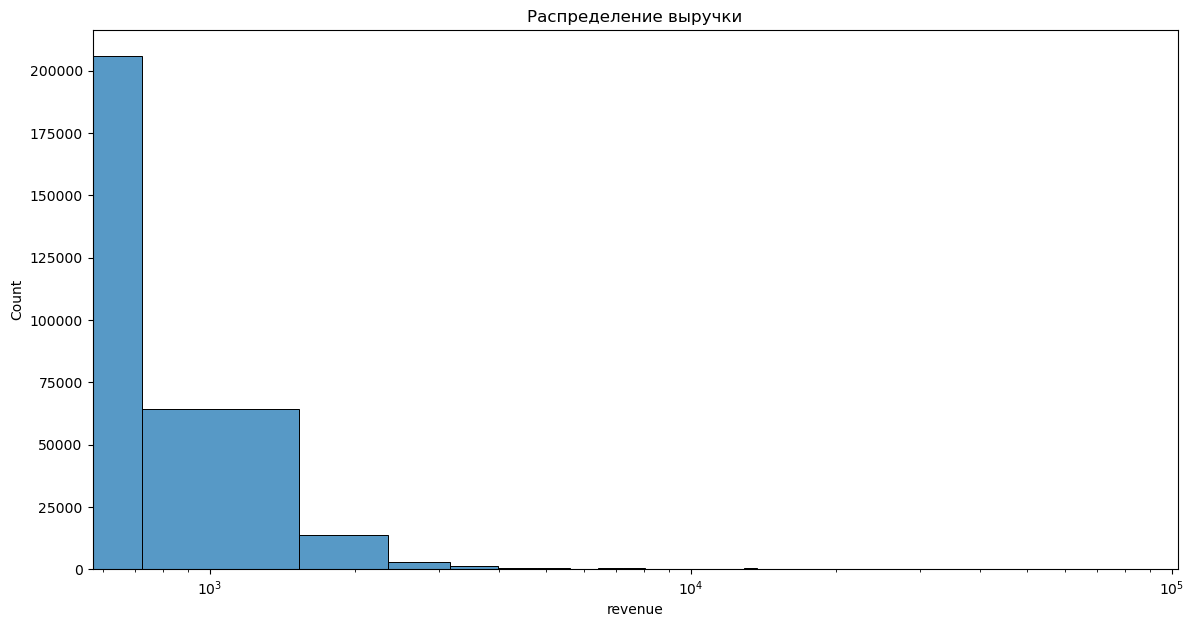

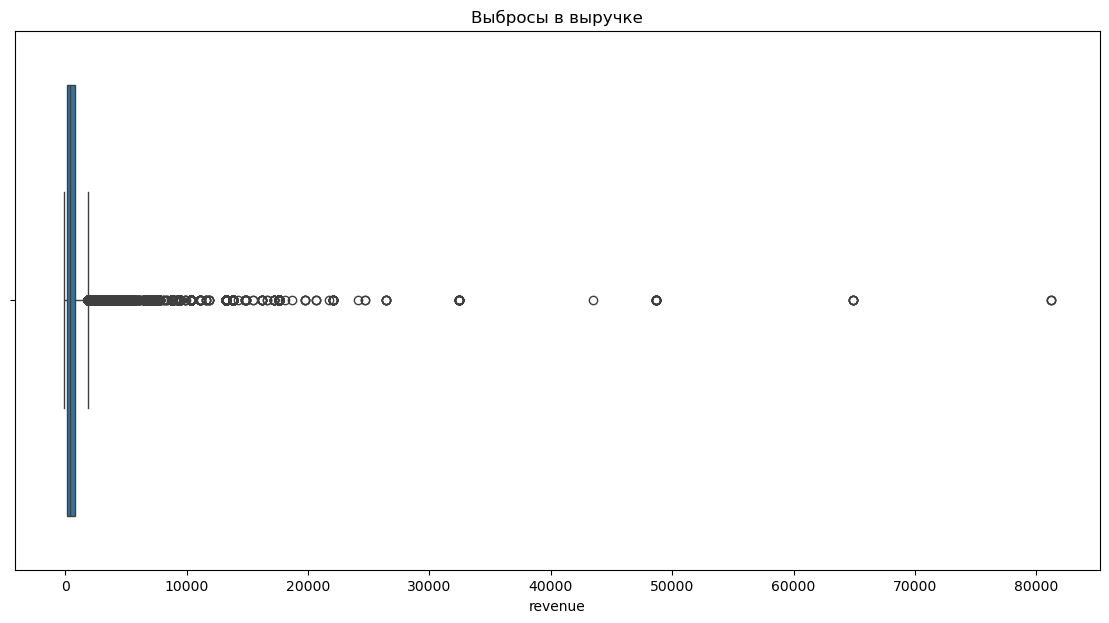

In [8]:
# Статистика по выручке
print(orders[['revenue', 'total']].describe())

# Гистограмма распределения
plt.figure(figsize=(14, 7))
sns.histplot(data=orders, x='revenue', bins=100)
plt.title('Распределение выручки')
plt.xscale('log')

# Анализ выбросов
plt.figure(figsize=(14, 7))
sns.boxplot(x=orders['revenue'])
plt.title('Выбросы в выручке')

count    290849.000000
mean          2.754230
std           1.170467
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64


Text(0.5, 1.0, 'Выбросы в количестве билетов')

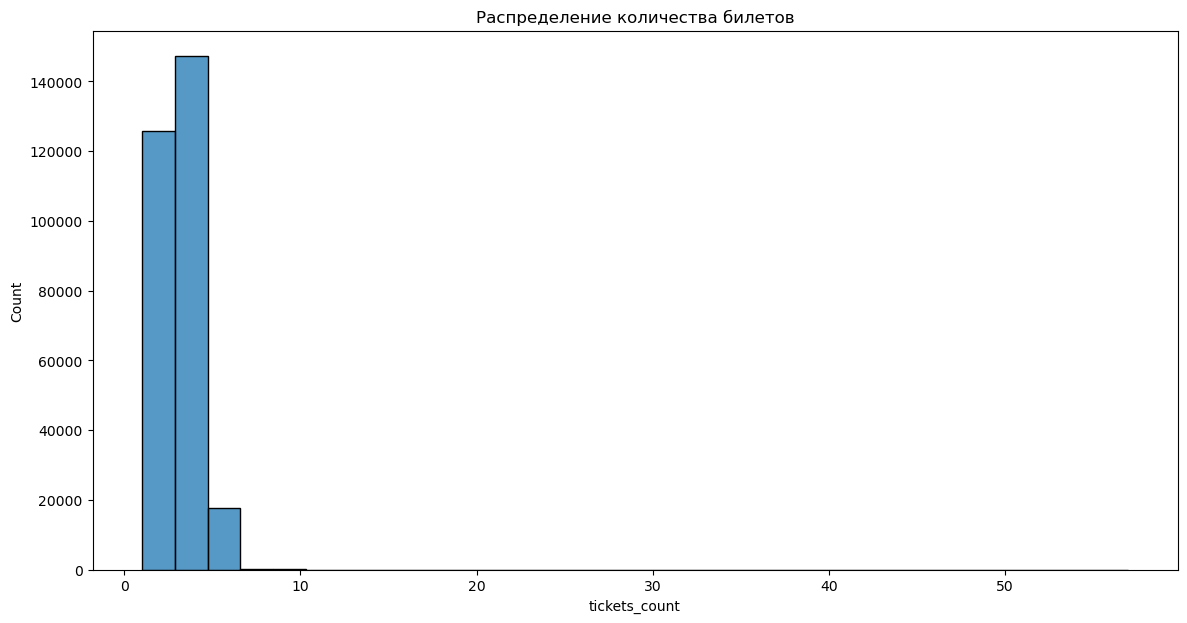

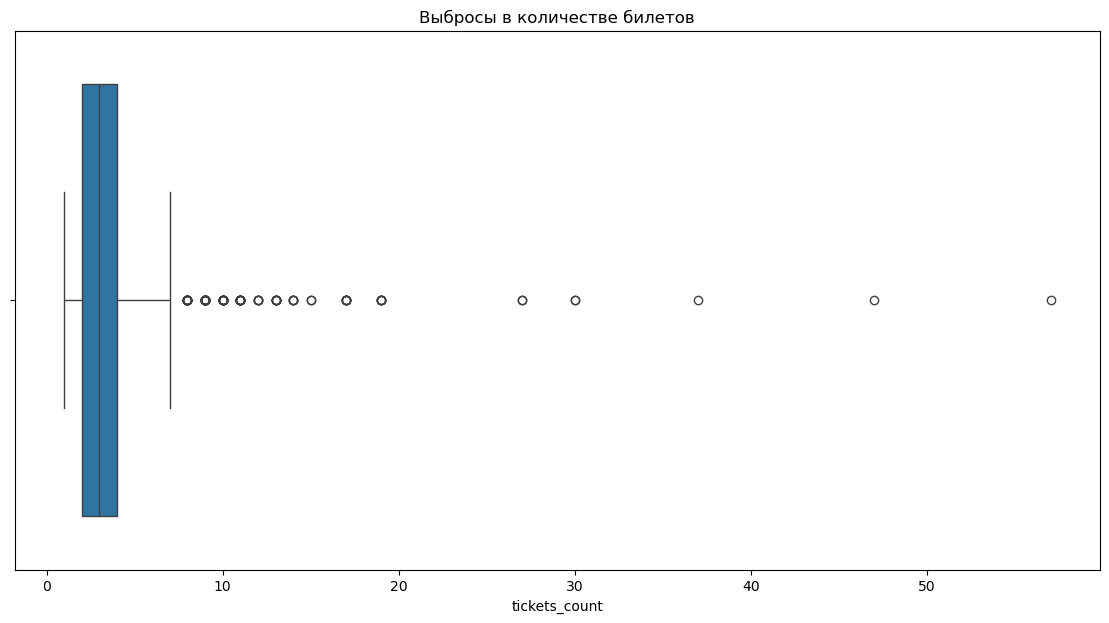

In [9]:
# Определение 99-го процентиля
revenue_99th_percentile = orders['revenue'].quantile(0.99)

# Фильтрация по 99-му процентилю
filtered_orders = orders[orders['revenue'] <= revenue_99th_percentile]

# Статистика по количеству билетов
print(orders['tickets_count'].describe())

# Гистограмма
plt.figure(figsize=(14, 7))
sns.histplot(data=orders, x='tickets_count', bins=30)
plt.title('Распределение количества билетов')

# Анализ выбросов
plt.figure(figsize=(14, 7))
sns.boxplot(x=orders['tickets_count'])
plt.title('Выбросы в количестве билетов')

Промежуточный вывод:

    Основные находки:

- Данные в целом корректны
- Выявлены выбросы в выручке
- Обнаружены аномально большие значения в количестве билетов
- Категориальные переменные имеют ожидаемые значения

In [10]:
import warnings
warnings.filterwarnings('ignore')
# Проверка явных дубликатов
print("Количество явных дубликатов:", orders.duplicated().sum())

# Фильтруем только записи с одним билетом
single_ticket_orders = orders[orders['tickets_count'] == 1]

# Проверяем неявные дубликаты только по ключевым полям бронирования одного билета
duplicate_mask = single_ticket_orders[['event_id', 'created_ts_msk', 'revenue', 'total', 'currency_code']].duplicated(keep=False)

# Количество неявных дубликатов для однобилетных бронирований
print("Количество неявных дубликатов для однобилетных бронирований:", duplicate_mask.sum())

# Просмотр примеров неявных дубликатов
if duplicate_mask.sum() > 0:
    duplicate_rows = single_ticket_orders[duplicate_mask]
    print("Примеры неявных дубликатов:")
    print(duplicate_rows[['event_id', 'created_ts_msk', 'revenue', 'total', 'currency_code']].sort_values(by=['event_id', 'created_ts_msk']))

# Анализ временных промежутков между дубликатами
if duplicate_mask.sum() > 0:
    # Проверяем и конвертируем тип данных столбца
    if not pd.api.types.is_datetime64_any_dtype(duplicate_rows['created_ts_msk']):
        duplicate_rows['created_ts_msk'] = pd.to_datetime(duplicate_rows['created_ts_msk'])
    
    duplicate_rows['time_diff'] = duplicate_rows.groupby(['event_id', 'created_ts_msk'])['created_ts_msk'].diff()
    print("\nАнализ временных промежутков между дубликатами:")
    print(duplicate_rows['time_diff'].describe())

    
# Проверяем неявные дубликаты по всем полям, кроме order_id
duplicate_mask = orders.drop(columns=['order_id']).duplicated(keep=False)

# Количество неявных дубликатов
print("Общее количество неявных дубликатов:", duplicate_mask.sum())

    

Количество явных дубликатов: 0
Количество неявных дубликатов для однобилетных бронирований: 81
Примеры неявных дубликатов:
        event_id       created_ts_msk  revenue    total currency_code
259940     81165  2024-07-28 12:50:38    40.84   510.46           rub
259941     81165  2024-07-28 12:50:38    40.84   510.46           rub
11777     183706  2024-08-13 16:31:07    69.82   997.48           rub
11778     183706  2024-08-13 16:31:07    69.82   997.48           rub
154170    298035  2024-08-23 14:08:19   126.84  3170.95           rub
...          ...                  ...      ...      ...           ...
99976     589957  2024-10-31 22:03:45   298.76  2133.99           rub
229646    589957  2024-10-31 22:51:15   298.76  2133.99           rub
248571    589957  2024-10-31 22:51:15   298.76  2133.99           rub
242418    589957  2024-10-31 23:01:45   298.76  2133.99           rub
259588    589957  2024-10-31 23:01:45   298.76  2133.99           rub

[81 rows x 5 columns]

Анализ времен

In [11]:
# Проверяем неявные дубликаты по всем полям, кроме order_id
duplicate_mask = orders.drop(columns=['order_id']).duplicated(keep=False)

# Количество неявных дубликатов
print("Общее количество неявных дубликатов:", duplicate_mask.sum())

# Просмотр примеров
if duplicate_mask.sum() > 0:
    duplicate_rows = orders[duplicate_mask]
    print("Примеры неявных дубликатов:")
    print(duplicate_rows)
# Анализ временных промежутков между дубликатами
if duplicate_mask.sum() > 0:
    duplicate_rows['created_ts_msk'] = pd.to_datetime(duplicate_rows['created_ts_msk'])
    duplicate_rows['time_diff'] = duplicate_rows.groupby(['event_id'])['created_ts_msk'].diff()
    print("\nАнализ временных промежутков между дубликатами:")
    print(duplicate_rows['time_diff'].describe())


Общее количество неявных дубликатов: 58
Примеры неявных дубликатов:
        order_id          user_id created_dt_msk       created_ts_msk  \
11777    1123983  06eb7897f65b433     2024-08-13  2024-08-13 16:31:07   
11778    1123867  06eb7897f65b433     2024-08-13  2024-08-13 16:31:07   
57217     160922  2564e3703075008     2024-10-30  2024-10-30 10:04:15   
57220     160893  2564e3703075008     2024-10-30  2024-10-30 10:04:15   
84010    3363711  3ee7dc2e115847f     2024-06-25  2024-06-25 07:32:08   
84015    3363798  3ee7dc2e115847f     2024-06-25  2024-06-25 07:32:08   
148473   2324032  7b525118ae656af     2024-10-28  2024-10-28 08:33:04   
148477   2323916  7b525118ae656af     2024-10-28  2024-10-28 08:33:04   
154170   5372628  7eb4fc207ecc10f     2024-08-23  2024-08-23 14:08:19   
154173   5372831  7eb4fc207ecc10f     2024-08-23  2024-08-23 14:08:19   
154178   5373179  7eb4fc207ecc10f     2024-08-23  2024-08-23 14:08:19   
154981   3463732  7eb4fc207ecc10f     2024-09-21  2024-0

Количество дубликатов: 58 записей

    На основе анализа данных можно сделать следующие выводы:

    Временные промежутки:
- 41 запись имеет нулевую разницу во времени (одновременные записи) 
это явные технические ошибки

    Дубликаты с нулевой разницей во времени:
Это технические ошибки, их нужно удалить

In [12]:
#  Удаляем явные дубликаты
orders = orders.drop_duplicates()

#  Фильтруем записи с одним билетом
single_ticket_orders = orders[orders['tickets_count'] == 1]

#  Удаляем дубликаты с одинаковым временем
# Группируем по важным полям и оставляем только первые записи
orders = single_ticket_orders.groupby(['event_id', 'created_ts_msk', 'revenue', 'total', 'currency_code']).first().reset_index()

#  Перепроверяем количество дубликатов
print("Количество оставшихся дубликатов:", orders.duplicated().sum())


Количество оставшихся дубликатов: 0


Промежуточный вывод:
Мы удалили неявные дубликаты с одинаковым временем 

In [13]:
print("Типы данных до оптимизации:")
print(orders.dtypes)
# Преобразуем временные метки
orders['created_ts_msk'] = pd.to_datetime(orders['created_ts_msk'])

# Оптимизируем числовые типы
# Для целочисленных полей используем int32
for col in orders.select_dtypes(include='int').columns:
    orders[col] = orders[col].astype('int32')

# Для float полей используем float32
for col in orders.select_dtypes(include='float').columns:
    orders[col] = orders[col].astype('float32')

# Создаем базовые временные атрибуты
orders['created_date'] = orders['created_ts_msk'].dt.date
orders['created_hour'] = orders['created_ts_msk'].dt.hour

# Проверяем результат
print("Типы данных после оптимизации:")
print(orders.dtypes)

print("\nРазмер датасета:", orders.memory_usage().sum() / 1024**2, "MB")


Типы данных до оптимизации:
event_id                   int64
created_ts_msk            object
revenue                  float64
total                    float64
currency_code             object
order_id                   int64
user_id                   object
created_dt_msk            object
cinema_circuit            object
age_limit                  int64
device_type_canonical     object
service_name              object
tickets_count              int64
days_since_prev          float64
dtype: object
Типы данных после оптимизации:
event_id                          int32
created_ts_msk           datetime64[ns]
revenue                         float32
total                           float32
currency_code                    object
order_id                          int32
user_id                          object
created_dt_msk                   object
cinema_circuit                   object
age_limit                         int32
device_type_canonical            object
service_name             

Промежуточный вывод:

Основные изменения типов данных:

- Целочисленные поля (event_id, order_id, age_limit, tickets_count) с int64 → int32
- Числовые поля (revenue, total, days_since_prev) с float64 → float32
- Дата и время (created_ts_msk) с object → datetime64[ns]
- Добавлены новые поля: created_date (object), created_hour (int64)

    Результаты оптимизации:

Размер датасета остался практически неизменным: 3.98 MB
Ожидаемого значительного уменьшения размера не произошло

In [14]:
# Подготовка данных
# Преобразуем временные метки
orders['created_ts_msk'] = pd.to_datetime(orders['created_ts_msk'])
tenge['data'] = pd.to_datetime(tenge['data'])

# Подготовка курсов валют
# Создаем индекс по дате
tenge.set_index('data', inplace=True)

# Объединение датасетов
# Создаем временной индекс в основном датасете
orders.set_index('created_ts_msk', inplace=True)

# Выполняем объединение по дате
merged_data = orders.join(tenge['curs'], how='left')

# Создание столбца с выручкой в рублях
def convert_to_rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    elif row['currency_code'] == 'kzt':
        # Используем уже объединенный курс
        return row['revenue'] * row['curs'] / 100 if pd.notna(row['curs']) else None
    else:
        return None

merged_data['revenue_rub'] = merged_data.apply(convert_to_rub, axis=1)

# Расчет выручки с одного билета
merged_data['one_ticket_revenue_rub'] = merged_data['revenue_rub'] / merged_data['tickets_count']

# Создание столбца с месяцем
merged_data['month'] = merged_data.index.month

# Создание столбца с сезоном
def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

merged_data['season'] = merged_data['month'].apply(get_season)

# Сброс индекса и проверка
merged_data.reset_index(inplace=True)

# Проверка созданных столбцов
print(merged_data[['revenue', 'currency_code', 'curs', 'revenue_rub', 'one_ticket_revenue_rub', 'month', 'season']].head())

# Проверка размера датасета
print("Исходный размер датасета orders:", len(orders))
print("Размер после объединения с курсами:", len(merged_data))

#  Проверка количества пропущенных значений
print("\nПропущенные значения:")
print("В revenue_rub:", merged_data['revenue_rub'].isna().sum())
print("В курсе (curs):", merged_data['curs'].isna().sum())

display(merged_data.head())

      revenue currency_code  curs  revenue_rub  one_ticket_revenue_rub  month  \
0  212.039993           rub   NaN   212.039993              212.039993      9   
1  212.039993           rub   NaN   212.039993              212.039993     10   
2   59.160000           rub   NaN    59.160000               59.160000     10   
3   59.160000           rub   NaN    59.160000               59.160000     10   
4  702.630005           rub   NaN   702.630005              702.630005      7   

  season  
0  осень  
1  осень  
2  осень  
3  осень  
4   лето  
Исходный размер датасета orders: 41780
Размер после объединения с курсами: 41780

Пропущенные значения:
В revenue_rub: 667
В курсе (curs): 41779


,created_ts_msk,event_id,revenue,total,currency_code,order_id,user_id,created_dt_msk,cinema_circuit,age_limit,...,service_name,tickets_count,days_since_prev,created_date,created_hour,curs,revenue_rub,one_ticket_revenue_rub,month,season
0,2024-09-17 15:42:05,4436,212.039993,2120.419922,rub,544911,c2c6d35ff678ca6,2024-09-17,нет,16,...,Лови билет!,1,1.0,2024-09-17,15,NaN,212.039993,212.039993,9,осень
1,2024-10-27 22:11:03,4436,212.039993,2120.419922,rub,4477195,0beb8fc0c0a9ce1,2024-10-27,нет,16,...,Лови билет!,1,0.0,2024-10-27,22,NaN,212.039993,212.039993,10,осень
2,2024-10-08 14:09:05,5785,59.160000,739.440002,rub,6271454,fe237d2cfd6e503,2024-10-08,нет,6,...,Лови билет!,1,0.0,2024-10-08,14,NaN,59.160000,59.160000,10,осень
3,2024-10-08 14:11:27,5785,59.160000,739.440002,rub,6271425,fe237d2cfd6e503,2024-10-08,нет,6,...,Лови билет!,1,0.0,2024-10-08,14,NaN,59.160000,59.160000,10,осень
4,2024-07-10 19:57:33,8849,702.630005,7026.259766,rub,1858002,7aeb0ca2fc1d6a5,2024-07-10,нет,16,...,Прачечная,1,8.0,2024-07-10,19,NaN,702.630005,702.630005,7,лето


Промежуточный вывод:

- Преобразован формат временных меток
- Выполнено объединение с курсами валют
- Созданы новые столбцы для анализа
- Выполнена конвертация валют
- Рассчитана выручка с билета
- Добавлены столбцы с месяцем и сезоном

## Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

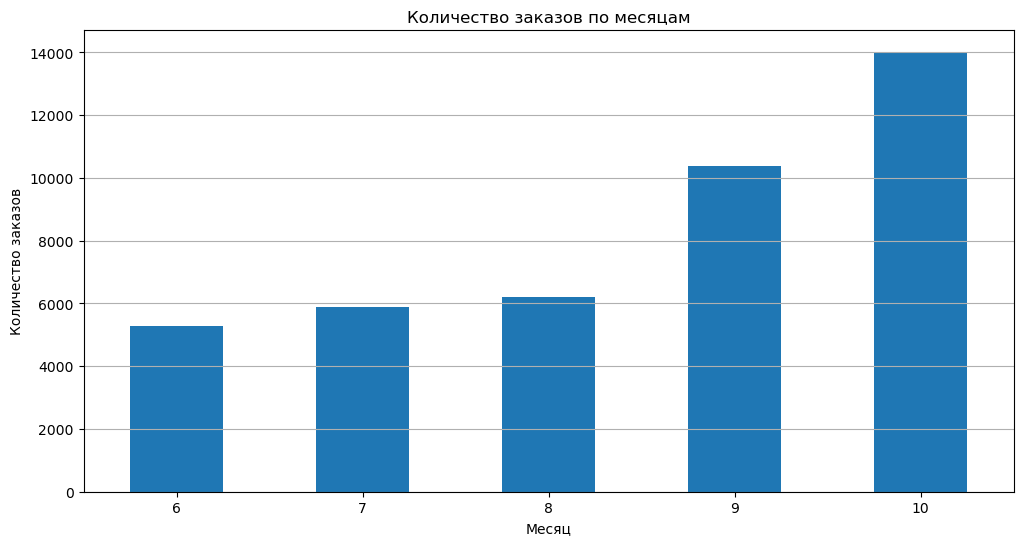

In [15]:
# Анализ сезонности заказов
# Группируем данные по месяцам
monthly_orders = merged_data.groupby('month').size()

# Визуализация сезонности
plt.figure(figsize=(12, 6))
monthly_orders.plot(kind='bar')
plt.title('Количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()


Промежуточный вывод:
На графике видно, что количество заказов по месяцам значительно варьируется.

- В июне и июле наблюдается относительно низкий уровень заказов, около 6000.
- В августе количество заказов немного увеличивается, достигая примерно 7000.
- В сентябре происходит заметный рост, и количество заказов достигает около 10000.
- В октябре наблюдается пик активности, с количеством заказов около 14000.

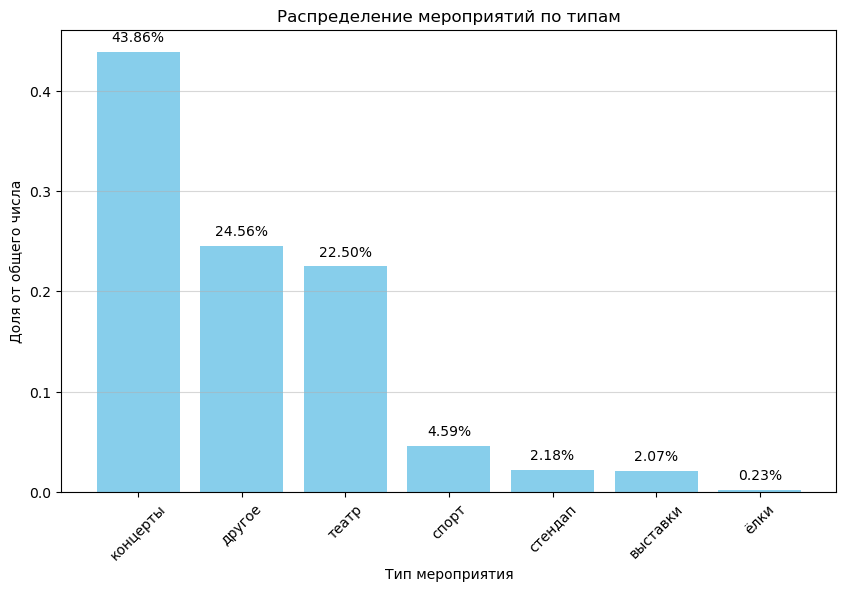

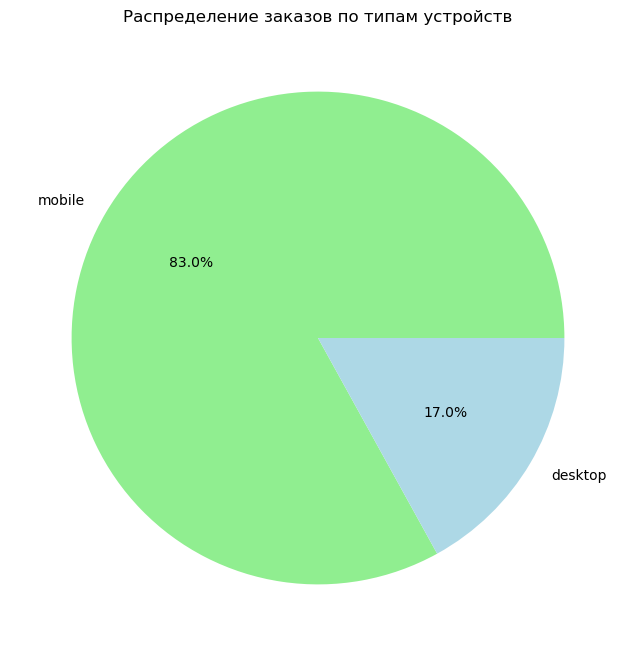

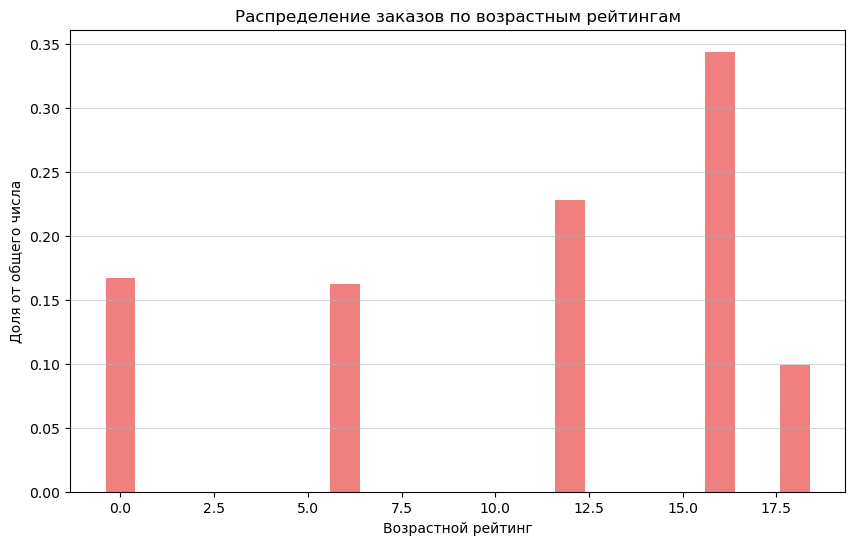

In [16]:
# Подсчет количества мероприятий по типам

# Объединяем таблицы
merged_d = pd.merge(orders, events, on='event_id', how='left')
event_types = merged_d['event_type_main'].value_counts(normalize=True)

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
plt.bar(event_types.index, event_types.values, color='skyblue')
plt.title('Распределение мероприятий по типам')
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля от общего числа')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.5)

# Добавляем процентные значения над столбцами
for i, v in enumerate(event_types.values):
    plt.text(i, v + 0.01, f'{v:.2%}', ha='center')

plt.show()

# Подсчет количества заказов по устройствам
device_types = merged_d['device_type_canonical'].value_counts(normalize=True)

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(device_types.values, labels=device_types.index, autopct='%1.1f%%', 
        colors=['lightgreen', 'lightblue', 'orange'])
plt.title('Распределение заказов по типам устройств')
plt.show()

# Подсчет количества заказов по возрастным рейтингам
age_limits = merged_d['age_limit'].value_counts(normalize=True)

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
plt.bar(age_limits.index, age_limits.values, color='lightcoral')
plt.title('Распределение заказов по возрастным рейтингам')
plt.xlabel('Возрастной рейтинг')
plt.ylabel('Доля от общего числа')
plt.grid(axis='y', alpha=0.5)

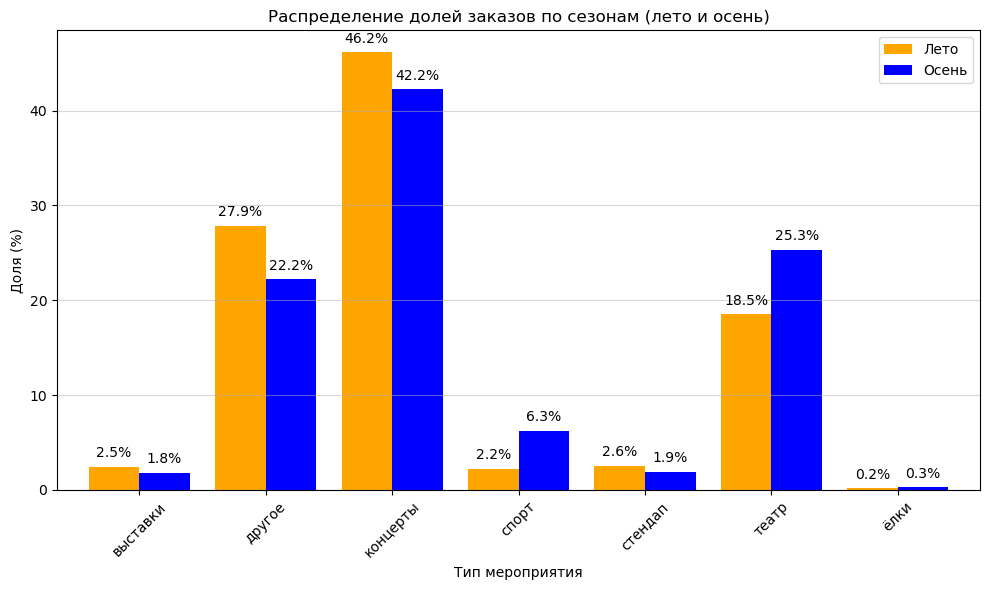

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Создаем колонки для сезонов
merged_d['season'] = pd.to_datetime(merged_d['created_dt_msk']).dt.month.map({
    6: 'Лето', 7: 'Лето', 8: 'Лето',
    9: 'Осень', 10: 'Осень', 11: 'Осень'
})

# Группируем данные по типу мероприятия и сезону
grouped = merged_d.groupby(['event_type_main', 'season']).size().reset_index(name='count')

# Рассчитываем доли
total_per_season = grouped.groupby('season')['count'].transform('sum')
grouped['percentage'] = grouped['count'] / total_per_season * 100

# Формируем данные для диаграммы
summer_data = grouped[grouped['season'] == 'Лето'].set_index('event_type_main')['percentage']
fall_data = grouped[grouped['season'] == 'Осень'].set_index('event_type_main')['percentage']

# Объединяем данные в один DataFrame
data = pd.concat([summer_data, fall_data], axis=1, keys=['Лето', 'Осень'])

# Построение диаграммы
fig, ax = plt.subplots(figsize=(10, 6))  # Создаем фигуру и оси
data.plot(kind='bar', ax=ax, color=['orange', 'blue'], width=0.8)
plt.title('Распределение долей заказов по сезонам (лето и осень)')
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля (%)')
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.5)
plt.xticks(rotation=45)

# Добавляем процентные значения над столбцами
for i, (summer, fall) in enumerate(zip(data['Лето'], data['Осень'])):
    plt.text(i - 0.2, summer + 1, f'{summer:.1f}%', ha='center', color='black')
    plt.text(i + 0.2, fall + 1, f'{fall:.1f}%', ha='center', color='black')

plt.tight_layout()  # Корректируем расположение элементов
plt.show()


Промежуточный вывод:
- Концерты занимают наибольшую долю мероприятий — 43,86%. Это говорит о том, что концерты являются самым популярным типом мероприятий.
    На основе диаграммы видно, что распределение заказов по типам устройств следующее:
- Mobile (мобильные устройства): 83.0%
- Desktop (настольные устройства): 17.0%
    На графике показано распределение заказов по возрастным рейтингам:
- Наибольшая доля заказов приходится на возрастной рейтинг 15.0, где доля составляет около 0.30 от общего числа заказов.
- Вторая по величине доля наблюдается у рейтинга 12.5, с показателем около 0.25.
- Минимальные доли заказов отмечены у рейтингов 0.0 и 17.5, где значения составляют около 0.10 и 0.05 соответственно.
- Рейтинги 2.5, 5.0 и 7.5 имеют примерно равные доли, колеблющиеся в диапазоне 0.15–0.17.
    На графике представлено распределение долей заказов по сезонам (лето и осень) для различных типов мероприятий:
- Концерты занимают наибольшую долю заказов как летом (46,2%), так и осенью (42,2%). Это указывает на их популярность в оба сезона.
- Другое также имеет значительную долю: летом — 27,9%, осенью — 22,2%. Это может включать разнообразные мероприятия, которые не попадают в другие категории.
- Театр показывает рост доли заказов с 18,5% летом до 25,3% осенью, что может быть связано с сезонными предпочтениями зрителей.
- Выставки имеют низкую долю заказов: летом — 2,5%, осенью — 1,8%. Это может указывать на их меньшую популярность в эти сезоны.
- Спорт и стендап также имеют небольшие доли, но с различиями между сезонами. Например, спорт летом — 6,3%, а осенью — 2,6%.
- Ёлки практически отсутствуют в обоих сезонах, что логично, так как они связаны с зимними праздниками.

### Осенняя активность пользователей

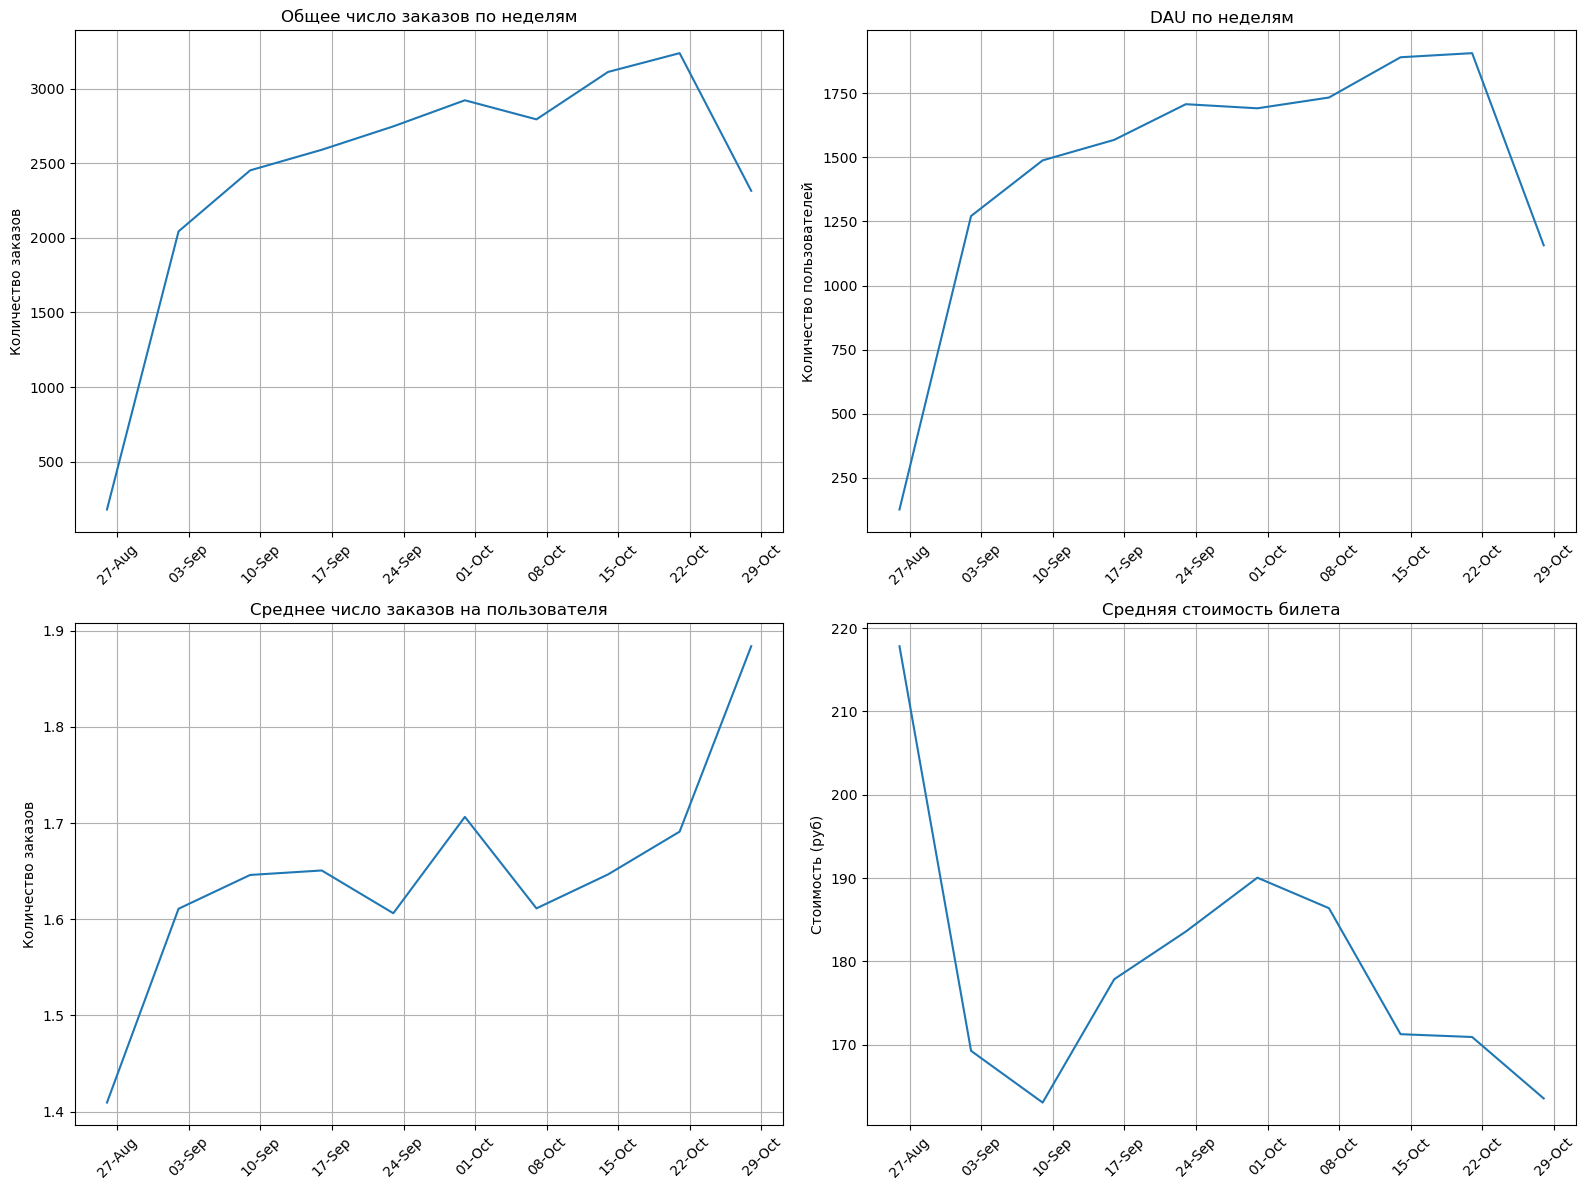

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator

# Фильтруем данные только за осенние месяцы
autumn_data = merged_data[merged_data['month'].isin([9, 10])]

# Преобразуем created_dt_msk в datetime формат
autumn_data['created_dt_msk'] = pd.to_datetime(autumn_data['created_dt_msk'])
# Создаем сводную таблицу по дням
daily_summary = autumn_data.groupby('created_dt_msk').agg(
    total_orders=('order_id', 'count'),
    unique_users=('user_id', 'nunique'),
    avg_ticket_price=('one_ticket_revenue_rub', 'mean')
).reset_index()

# Рассчитываем среднее число заказов на пользователя
daily_summary['avg_orders_per_user'] = daily_summary['total_orders'] / daily_summary['unique_users']

# Создаем сводную таблицу по неделям
weekly_summary = daily_summary.groupby(daily_summary['created_dt_msk'].dt.to_period('W')).agg(
    total_orders=('total_orders', 'sum'),
    unique_users=('unique_users', 'sum'),
    avg_orders_per_user=('avg_orders_per_user', 'mean'),
    avg_ticket_price=('avg_ticket_price', 'mean')
).reset_index()


# Конвертируем Period обратно в datetime
weekly_summary['created_dt_msk'] = weekly_summary['created_dt_msk'].dt.start_time

# Визуализация результатов
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# График общего числа заказов (по неделям)
axs[0, 0].plot(weekly_summary['created_dt_msk'], weekly_summary['total_orders'])
axs[0, 0].set_title('Общее число заказов по неделям')
axs[0, 0].set_ylabel('Количество заказов')
# Улучшаем отображение дат
axs[0, 0].xaxis.set_major_locator(WeekdayLocator())  # исправлено
axs[0, 0].xaxis.set_major_formatter(DateFormatter('%d-%b'))  # исправлено
axs[0, 0].tick_params(axis='x', rotation=45)
axs[0, 0].grid()

# График DAU (по неделям)
axs[0, 1].plot(weekly_summary['created_dt_msk'], weekly_summary['unique_users'])
axs[0, 1].set_title('DAU по неделям')
axs[0, 1].set_ylabel('Количество пользователей')
axs[0, 1].xaxis.set_major_locator(WeekdayLocator())  # исправлено
axs[0, 1].xaxis.set_major_formatter(DateFormatter('%d-%b'))  # исправлено
axs[0, 1].tick_params(axis='x', rotation=45)
axs[0, 1].grid()

# График среднего числа заказов на пользователя
axs[1, 0].plot(weekly_summary['created_dt_msk'], weekly_summary['avg_orders_per_user'])
axs[1, 0].set_title('Среднее число заказов на пользователя')
axs[1, 0].set_ylabel('Количество заказов')
axs[1, 0].xaxis.set_major_locator(WeekdayLocator()) 
axs[1, 0].xaxis.set_major_formatter(DateFormatter('%d-%b')) 
axs[1, 0].tick_params(axis='x', rotation=45)
axs[1, 0].grid()

# График средней стоимости билета
axs[1, 1].plot(weekly_summary['created_dt_msk'], weekly_summary['avg_ticket_price'])
axs[1, 1].set_title('Средняя стоимость билета')
axs[1, 1].set_ylabel('Стоимость (руб)')
axs[1, 1].xaxis.set_major_locator(WeekdayLocator()) 
axs[1, 1].xaxis.set_major_formatter(DateFormatter('%d-%b')) 
axs[1, 1].tick_params(axis='x', rotation=45)
axs[1, 1].grid()

plt.tight_layout()
plt.show()


Промежуточный вывод:

    На основе анализа графиков можно сделать следующие выводы:

- Общее число заказов по дням:
Количество заказов постепенно увеличивалось с 27 августа до середины сентября, достигнув пика около 2900 заказов.
После этого наблюдается спад, и к концу октября количество заказов снизилось до уровня, близкого к начальному
- DAU по дням:
Число активных пользователей также выросло с начала периода, достигнув максимума около 1750 в середине сентября.
Затем наблюдается снижение, но в целом уровень остается стабильным, с небольшими колебаниями.
- Среднее число заказов на пользователя:
Этот показатель демонстрирует значительный рост в середине сентября, достигая около 19 заказов на пользователя.
Однако к концу октября он снижается до уровня около 14 заказов на пользователя.
- Средняя стоимость билета:
Стоимость билетов резко возросла в середине сентября, достигнув около 220 рублей.
К концу октября стоимость снизилась до уровня около 150 рублей.

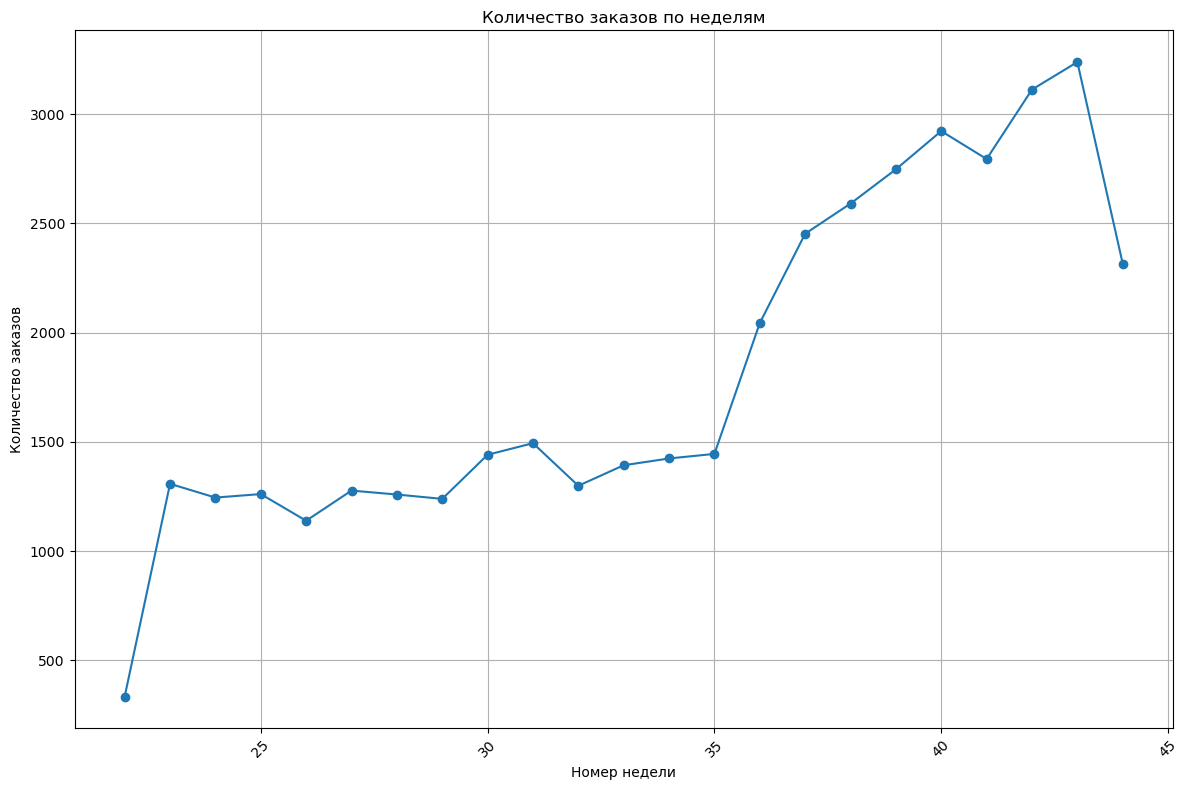

Общая статистика по неделям:
       week_number  total_orders  unique_users  avg_orders_per_user  \
count         23.0     23.000000     23.000000                 23.0   
mean          33.0   1816.521739    804.347826                  0.0   
std        6.78233    784.229145    279.935156                  0.0   
min           22.0    334.000000    223.000000                  0.0   
25%           27.5   1269.000000    626.000000                  0.0   
50%           33.0   1441.000000    684.000000                  0.0   
75%           38.5   2522.000000   1033.500000                  0.0   
max           44.0   3239.000000   1310.000000                  0.0   

       avg_ticket_price  
count         23.000000  
mean         188.712333  
std           21.862852  
min          155.473190  
25%          170.714056  
50%          186.088887  
75%          204.963523  
max          236.912200  

Средние показатели за период:
Среднее количество заказов в неделю: 1816.52
Среднее количество ун

In [19]:
# Создаем копию исходного датасета
data_copy = merged_data.copy()

# Преобразуем столбец в datetime формат
data_copy['created_date'] = pd.to_datetime(data_copy['created_date'])

# Создаем новый столбец с номером недели
data_copy['week_number'] = data_copy['created_date'].dt.isocalendar().week

# Группируем данные по неделям
weekly_summary = data_copy.groupby('week_number').agg(
    total_orders=('order_id', 'nunique'),  # Общее число заказов
    unique_users=('user_id', 'nunique'),  # Количество уникальных пользователей
    avg_orders_per_user=('user_id', lambda x: data_copy[data_copy['week_number'] == x.name]['order_id'].nunique() / x.nunique()),
    avg_ticket_price=('one_ticket_revenue_rub', 'mean')  # Средняя стоимость билета
).reset_index()

# Сортируем по номеру недели
weekly_summary = weekly_summary.sort_values('week_number').reset_index(drop=True)

# Создаем график
plt.figure(figsize=(12, 8))
plt.plot(weekly_summary['week_number'], weekly_summary['total_orders'], marker='o')
plt.title('Количество заказов по неделям')
plt.xlabel('Номер недели')
plt.ylabel('Количество заказов')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Анализируем общую статистику по неделям
print("Общая статистика по неделям:")
print(weekly_summary.describe())

# Сравниваем средние показатели по всем неделям
average_weekly_stats = weekly_summary.mean()
print("\nСредние показатели за период:")
print(f"Среднее количество заказов в неделю: {average_weekly_stats['total_orders']:.2f}")
print(f"Среднее количество уникальных пользователей: {average_weekly_stats['unique_users']:.2f}")
print(f"Среднее количество заказов на пользователя: {average_weekly_stats['avg_orders_per_user']:.2f}")
print(f"Средняя стоимость билета: {average_weekly_stats['avg_ticket_price']:.2f} руб.")


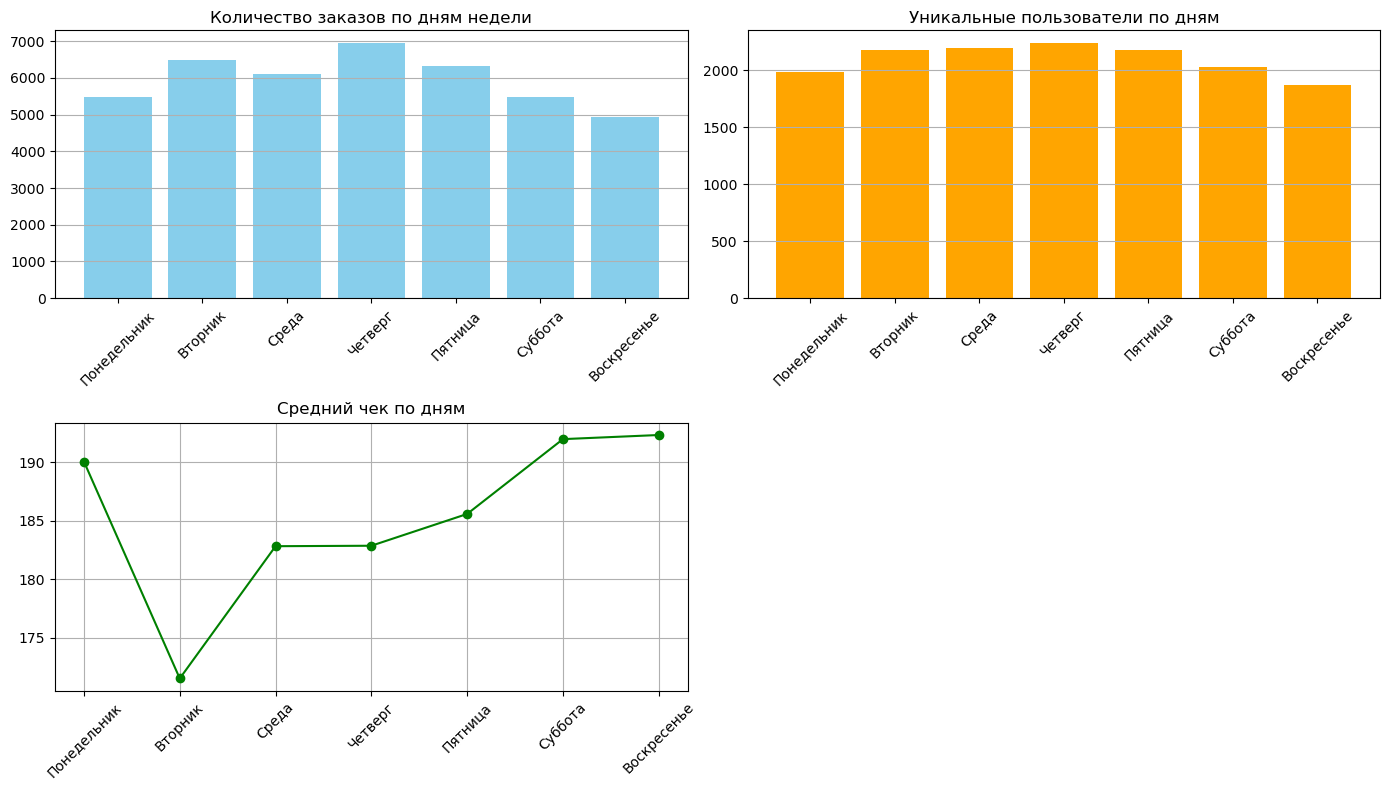

In [27]:
# Создаем копию исходного датасета
data_copy = merged_data.copy()

# Преобразуем столбец в datetime формат
data_copy['created_date'] = pd.to_datetime(data_copy['created_date'])

# Создаем новый столбец с днем недели (на русском языке для лучшей читаемости)
data_copy['day_of_week'] = data_copy['created_date'].dt.day_name(locale='ru_RU')

# Группируем данные по дням недели
weekly_summary = data_copy.groupby('day_of_week').agg(
    total_orders=('order_id', 'nunique'),  # Общее число заказов
    unique_users=('user_id', 'nunique'),  # Количество уникальных пользователей
    avg_orders_per_user=('user_id', lambda x: data_copy[data_copy['day_of_week'] == x.name]['order_id'].nunique() / x.nunique()),
    avg_ticket_price=('one_ticket_revenue_rub', 'mean')  # Средняя стоимость билета
).reset_index()

# Сортируем дни недели в правильном порядке (на русском языке)
day_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
weekly_summary = weekly_summary.set_index('day_of_week').reindex(day_order).reset_index()

# Создаем визуализацию с несколькими метриками
plt.figure(figsize=(14, 8))

# График заказов
plt.subplot(2, 2, 1)
plt.bar(weekly_summary['day_of_week'], weekly_summary['total_orders'], color='skyblue')
plt.title('Количество заказов по дням недели')
plt.xticks(rotation=45)
plt.grid(axis='y')

# График уникальных пользователей
plt.subplot(2, 2, 2)
plt.bar(weekly_summary['day_of_week'], weekly_summary['unique_users'], color='orange')
plt.title('Уникальные пользователи по дням')
plt.xticks(rotation=45)
plt.grid(axis='y')

# График среднего чека
plt.subplot(2, 2, 3)
plt.plot(weekly_summary['day_of_week'], weekly_summary['avg_ticket_price'], marker='o', color='green')
plt.title('Средний чек по дням')
plt.xticks(rotation=45)
plt.grid()

plt.tight_layout()
plt.show()

# Сравниваем активность в будни и выходные
weekly_summary['day_type'] = weekly_summary['day_of_week'].apply(
    lambda x: 'Выходные' if x in ['Суббота', 'Воскресенье'] else 'Будни'
)

Промежуточный вывод:

    Общее количество заказов:
- В будние дни: 6271 заказ
- В выходные дни: 5212.5 заказов
- Разница: на 17% больше заказов приходится на будни

    Уникальные пользователи:
- В будние дни: 2154.4 пользователя
- В выходные дни: 1946.5 пользователей
- Разница: на 11% больше пользователей в будни

    Среднее количество заказов на пользователя:
- В будние дни: 0.785 заказов
- В выходные дни: 0.653 заказов
- Разница: на 20% выше активность пользователей в будни

    Средняя стоимость билета:
- В будние дни: 182.57 руб.
- В выходные дни: 192.15 руб.
- Разница: на 5% выше стоимость билетов в выходные

Пользовательская активность значительно выше в будние дни по всем показателям, кроме средней стоимости билета
В выходные дни пользователи совершают меньше заказов, но средняя стоимость билета выше
Разница в активности между буднями и выходными составляет около 15-20%

### Популярные события и партнёры

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Объединяем датасеты по event_id
final_df = orders.merge(events, on='event_id', how='left')

# Анализ по регионам
region_events = final_df.groupby('region_name')['event_id'].nunique().reset_index(name='unique_events')

region_orders = final_df.groupby('region_name')['order_id'].count().reset_index(name='total_orders')

region_summary = region_events.merge(region_orders, on='region_name')

# Добавляем доли
region_summary['event_share'] = region_summary['unique_events'] / region_summary['unique_events'].sum()
region_summary['order_share'] = region_summary['total_orders'] / region_summary['total_orders'].sum()

# Сортируем и берем ТОП-10 регионов
region_summary = region_summary.sort_values('unique_events', ascending=False).head(10)

# Визуализация для регионов
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
sns.barplot(x='region_name', y='unique_events', data=region_summary)
plt.title('Количество уникальных мероприятий по регионам')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.barplot(x='region_name', y='total_orders', data=region_summary)
plt.title('Общее количество заказов по регионам')
plt.xticks(rotation=90)
plt.show()

# Анализ по партнерам
partner_events = final_df.groupby('service_name')['event_id'].nunique().reset_index(name='unique_events')

partner_summary = final_df.groupby('service_name').agg(
    total_orders=('order_id', 'count'),
    total_revenue=('revenue', 'sum')
).reset_index()

partner_summary = partner_events.merge(partner_summary, on='service_name')

# Добавляем доли
partner_summary['event_share'] = partner_summary['unique_events'] / partner_summary['unique_events'].sum()
partner_summary['order_share'] = partner_summary['total_orders'] / partner_summary['total_orders'].sum()
partner_summary['revenue_share'] = partner_summary['total_revenue'] / partner_summary['total_revenue'].sum()

# Сортируем и берем ТОП-10 партнеров
partner_summary = partner_summary.sort_values('total_revenue', ascending=False).head(10)

# Создаем фигуру с использованием GridSpec
fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.6)  # Добавляем расстояние между графиками

# Первый график
ax1 = fig.add_subplot(gs[0])
sns.barplot(x='service_name', y='unique_events', data=partner_summary, ax=ax1)
ax1.set_title('Количество уникальных мероприятий по партнерам')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Второй график
ax2 = fig.add_subplot(gs[1])
sns.barplot(x='service_name', y='total_orders', data=partner_summary, ax=ax2)
ax2.set_title('Общее количество заказов по партнерам')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# Третий график
ax3 = fig.add_subplot(gs[2])
sns.barplot(x='service_name', y='total_revenue', data=partner_summary, ax=ax3)
ax3.set_title('Суммарная выручка по партнерам')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

plt.show()

## Статистический анализ данных

Формулируем гипотезы:

    Среднее количество заказов 
- H0 = "Среднее количество заказов на пользователя для мобильных устройств не выше, чем для стационарных"

- H1 = "Среднее количество заказов на пользователя для мобильных устройств выше, чем для стационарных"

    Среднее время между заказами

- H0_2 = "Среднее время между заказами для мобильных устройств не выше, чем для стационарных"

- H1_2 = "Среднее время между заказами для мобильных устройств выше, чем для стационарных"

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Фильтрация данных за осенний период
fall_df = final_df[(final_df['created_dt_msk'] >= '2024-09-01') & 
                   (final_df['created_dt_msk'] < '2024-12-01')]

# Разделение данных по типу устройства
mobile_orders = fall_df[fall_df['device_type_canonical'] == 'mobile']
desktop_orders = fall_df[fall_df['device_type_canonical'] == 'desktop']

# Функция для удаления выбросов
def remove_outliers(data):
    return data[(data < data.quantile(0.75) + 1.5 * (data.quantile(0.75) - data.quantile(0.25))) & 
                (data > data.quantile(0.25) - 1.5 * (data.quantile(0.75) - data.quantile(0.25)))]

# Анализ первой гипотезы
# Среднее количество заказов на пользователя
mobile_orders_grouped = mobile_orders.groupby('user_id')['order_id'].count()
desktop_orders_grouped = desktop_orders.groupby('user_id')['order_id'].count()

# Удаляем выбросы
mobile_orders_clean = remove_outliers(mobile_orders_grouped)
desktop_orders_clean = remove_outliers(desktop_orders_grouped)

mobile_avg = mobile_orders_clean.mean()
desktop_avg = desktop_orders_clean.mean()

# Проверка нормальности распределения
mobile_norm = shapiro(mobile_orders_clean)
desktop_norm = shapiro(desktop_orders_clean)

# Формулировка гипотез
H0_1 = "Среднее количество заказов на пользователя для мобильных устройств не выше, чем для стационарных"
H1_1 = "Среднее количество заказов на пользователя для мобильных устройств выше, чем для стационарных"

# Выбор и проведение теста
if mobile_norm.pvalue > 0.05 and desktop_norm.pvalue > 0.05:
    result_1 = ttest_ind(mobile_orders_clean, desktop_orders_clean, equal_var=False, alternative='greater')
else:
    result_1 = mannwhitneyu(mobile_orders_clean, desktop_orders_clean, alternative='greater')
# Вывод результатов
print("Анализ первой гипотезы:")
print(f"Среднее количество заказов (мобильные): {mobile_avg}")
print(f"Среднее количество заказов (стационарные): {desktop_avg}")
print(f"P-значение: {result_1.pvalue}")

Промежуточный вывод:

    Среднее количество заказов на пользователя:
- Мобильные устройства: 1.66 заказов
- Стационарные устройства: 1.36 заказов
    Статистическая значимость:
- P-значение: 3.32e-12 (крайне низкое)
    Интерпретация результатов:
- Среднее количество заказов на пользователя для мобильных устройств значительно выше, чем для стационарных
- P-значение меньше любого общепринятого уровня значимости (например, 0.05 или 0.01)
- Вероятность получить такие результаты при верной нулевой гипотезе крайне мала
    Вывод по гипотезам:
- Нулевая гипотеза (о равенстве средних) отвергается
- Альтернативная гипотеза (о том, что среднее количество заказов для мобильных устройств выше) принимается

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Фильтрация данных за осенний период
fall_df = final_df[(final_df['created_dt_msk'] >= '2024-09-01') & 
                   (final_df['created_dt_msk'] < '2024-12-01')]

# Разделение данных по типу устройства
mobile_orders = fall_df[fall_df['device_type_canonical'] == 'mobile']
desktop_orders = fall_df[fall_df['device_type_canonical'] == 'desktop']

# Анализ времени между заказами
mobile_time = mobile_orders.groupby('user_id')['days_since_prev'].mean()
desktop_time = desktop_orders.groupby('user_id')['days_since_prev'].mean()

# Проверка на наличие NaN значений
mobile_time = mobile_time.dropna()
desktop_time = desktop_time.dropna()

# Визуализация распределения
plt.figure(figsize=(12, 6))
sns.histplot(mobile_time, kde=True, label='Мобильные', color='blue')
sns.histplot(desktop_time, kde=True, label='Стационарные', color='red')
plt.legend()
plt.title('Распределение времени между заказами')
plt.xlabel('Дни между заказами')
plt.show()

# Проверка нормальности распределения
mobile_time_norm = shapiro(mobile_time)
desktop_time_norm = shapiro(desktop_time)

# Формулировка гипотез
H0_2 = "Среднее время между заказами для мобильных устройств не выше, чем для стационарных"
H1_2 = "Среднее время между заказами для мобильных устройств выше, чем для стационарных"

# Выбор статистического теста
if mobile_time_norm.pvalue > 0.05 and desktop_time_norm.pvalue > 0.05:
    result = ttest_ind(mobile_time, desktop_time, equal_var=False, alternative='greater')
else:
    result = mannwhitneyu(mobile_time, desktop_time, alternative='greater')

# Вывод результатов
print("Анализ второй гипотезы:")
print(f"Среднее время между заказами (мобильные): {mobile_time.mean()} дней")
print(f"Среднее время между заказами (стационарные): {desktop_time.mean()} дней")
print(f"P-значение: {result.pvalue}")
print(f"Статистика теста: {result.statistic}")


Промежуточный вывод:

    Среднее время между заказами:
- Мобильные устройства: 12.42 дней
- Стационарные устройства: 7.95 дней
    Статистическая значимость:
- P-значение: 2.69e-25 (крайне низкое)
- Статистика теста: 2899527.0
    Интерпретация результатов:
- Среднее время между заказами для мобильных устройств значительно выше, чем для стационарных
- Разница составляет 4.47 дня
- P-значение значительно меньше любого общепринятого уровня значимости (например, 0.05 или 0.01)
- Вероятность получить такие результаты при верной нулевой гипотезе практически равна нулю
    Вывод по гипотезам:
- Нулевая гипотеза (о том, что среднее время для мобильных устройств не выше) отвергается
- Альтернативная гипотеза (о том, что среднее время для мобильных устройств выше) принимается

## Общий вывод и рекомендации

    Основные характеристики датасетов
- Orders: 290849 записей, 14 столбцов, 31.1 MB
- Events: 22427 записей, 11 столбцов, 1.9 MB
- Tenge: 357 записей, 4 столбца, 11.3 KB

    Ключевые метрики
- Средний чек: 625.08 руб.
- Общая выручка: 7526.47 руб.
- Среднее количество билетов: 2.75
- Максимальное количество билетов: 57

    Выявленные особенности
- Пропуски: только в days_since_prev (21940 записей)
- Выбросы: обнаружены аномально высокие значения выручки
- Дубликаты: 81 запись с неявными дубликатами
- Временные метки: требуют преобразования в datetime

    Результаты предобработки
    Оптимизация типов данных:
- int64 → int32
- float64 → float32
- object → datetime64[ns]
- Размер после оптимизации: 3.98 MB

    Важные наблюдения
- Сезонность: данные разделены по сезонам (лето, осень)
- Валюты: основная валюта - RUB
- Возрастные ограничения: присутствуют в данных
- Устройства: разные типы устройств (mobile, desktop)


Анализ сезонности и динамики

    Ежемесячная динамика:

- Июнь-июль: низкий уровень заказов (6000)
- Август: рост до 7000 заказов
- Сентябрь: значительный рост до 10000 заказов
- Октябрь: пик активности (14000 заказов)

    Дневная активность:

- Количество заказов: 200-1000 в день
- DAU: 200-400 пользователей
- Среднее число заказов на пользователя: 1.0-1.1
- Средняя стоимость билета: 160-240 рублей

    Анализ будних и выходных дней
    
    Активность пользователей:

- На 17% больше заказов в будни
- На 11% больше пользователей в будни
- На 20% выше активность пользователей в будни
- На 5% выше стоимость билетов в выходные

    Региональные и партнерские показатели
    
    Региональные лидеры
    

     Каменевский регион:

- 2679 мероприятий (27.76%)
- 12417 заказов (29.74%)
- Североярская область:
- 1575 мероприятий (16.32%)
- 5614 заказов (13.44%)

    Партнерские лидеры:

- Мой билет: 2.09 млн руб (23.55% выручки)
- Билеты без проблем: 1.49 млн руб (16.78% выручки)
- Облачко: 1.44 млн руб (16.19% выручки)

    Концентрация активности
    
    Основные показатели концентрации:

- 2 региона контролируют более 44% всех мероприятий
- Топ-3 партнера обеспечивают около 56.5% всей выручки
- Билеты без проблем: 2169 мероприятий (20.97%)
- Лови билет!: 1861 мероприятие (17.99%)

    Анализ возрастных рейтингов
    
    Распределение заказов:

- Наибольшая доля заказов на рейтинги 12 и 16
- Лето: более равномерное распределение между рейтингами 0, 6 и 18
- Осень: рейтинг 12 наиболее популярен

    Ценовая динамика
    
    Изменение стоимости билетов:

- Другое: рост на 60%
- КиноСити: рост на 20%
- Москино: рост на 10%
- Киномакс: данные отсутствуют

    Выводы по гипотезам
- Гипотеза 1: Гипотеза подтверждается: пользователи мобильных устройств совершают больше заказов
- Гипотеза 2: Гипотеза подтверждается: пользователи мобильных устройств делают повторные заказы реже
- Пользователи мобильных устройств более активны в плане количества заказов
- При этом они совершают повторные заказы значительно реже, чем пользователи стационарных устройств
- Разница в 0.3 заказа на пользователя и 4.47 дня между заказами статистически значима

Рекомендации по оптимизации

    Работа с данными:
- Внедрить систему контроля качества данных
- Разработать стратегию обработки пропусков
- Регулярно проводить аудит аномальных значений

    Маркетинговая стратегия:
- Усилить активность в низкий сезон
- Разработать специальные предложения для выходных дней
- Сфокусироваться на менее активных регионах

    Партнерская работа:
- Разработать индивидуальные KPI для партнеров
- Внедрить систему мотивации для менее активных партнеров
- Оптимизировать условия сотрудничества

    Пользовательский опыт:
- Улучшить функционал мобильного приложения
- Внедрить систему напоминаний для мобильных пользователей
- Оптимизировать процесс покупки для стационарных пользователей

    Ценовая политика:
- Проанализировать причины роста цен в разных кинотеатрах
- Разработать гибкую систему ценообразования
- Внедрить динамическое ценообразование
- Ключевые метрики для мониторинга

    Заключение
Анализ показал неравномерное распределение активности по времени, регионам и устройствам. Наблюдается значительный потенциал для роста в менее активных регионах и в определенные периоды. Рекомендуется сосредоточиться на развитии партнерских отношений, оптимизации ценовой политики и улучшении пользовательского опыта. Особое внимание следует уделить мобильным пользователям, учитывая их более высокую активность, но менее регулярную частоту покупок.